In [91]:
# ! python -c "import pykeen" || pip install git+https://github.com/pykeen/pykeen.git
# pykeen.env()

In [19]:
import os
import pandas as pd
import numpy as np
import scprep

import torch


print(os.getcwd())
base_dir = f"{os.getcwd()}"

/Users/ferran/PhD/yaleCollab


# Explore PyKEEN and default data

In [93]:
# import pandas as pd

# from pykeen.triples import TriplesFactory
# from pykeen.pipeline import pipeline
# from pykeen.datasets.nations import NATIONS_TRAIN_PATH

# tf = TriplesFactory.from_path(NATIONS_TRAIN_PATH)

# print(NATIONS_TRAIN_PATH)
# print(tf)

# # training, testing = tf.split()

# # result = pipeline(

# #     training=training,

# #     testing=testing,

# #     model='TransE',

# #     epochs=5,  # short epochs for testing - you should go higher

# # )

# # result.save_to_directory('doctests/test_unstratified_transe')

In [94]:
# pd.read_csv('/usr/local/lib/python3.9/site-packages/pykeen/datasets/nations/train.txt', sep='\t')

Format data for PYKEEN is in the form of a TSV file with the (h,r,t) format.
THis means that the edges are indeed directed.

WEe can now take either one of two approaches:

- Use STRING database ass a proof of concept. All of these interactions will be considered as @signsallnig interactions. KG will end up having 2 types of edges: those from strign and those from cellchat
- Proper approach with the Functional INteraction network from reactome. Here interaction edges can be of different types, and string comprehension will have to be built to decode the direction column into individual triplets with the (h,r,t) format

## RPY2 cheatsheet

Using R from Python

In [95]:
# import rpy2
# import rpy2.situation
# for row in rpy2.situation.iter_info(): # Print Rpy2 info
#     print(row)

# from rpy2.robjects.packages import importr
# base = importr("base")
# here = importr("here")

# if here.here()[0] != base_dir:
#     raise ValueError

In [96]:
# from rpy2.robjects.packages import importr
# base = importr("base")
# here = importr("here")

# INTepi21 = base.readRDS(here.here("CRCTME_story/Integration_CRCTME-Aug21/RData",
# "INTepi21_filt_2022.rds"))
# INTepi21

Load R chunks

In [97]:
# %load_ext rpy2.ipython

In [98]:
# %%R
# R.version.string

In [99]:
# %%R -i INTepi21
# library(base)
# library(tidyverse)
# library(Seurat)
# library(here)

# INTepi21

# STRING + CellchatDB KGE

In [100]:
import rpy2
import rpy2.situation
for row in rpy2.situation.iter_info(): # Print Rpy2 info
    print(row)

from rpy2.robjects.packages import importr
base = importr("base")
here = importr("here")

if here.here()[0] != base_dir:
    raise ValueError

from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

rpy2 version:
3.4.5
Python version:
3.9.13 (main, Aug  7 2022, 01:33:23) 
[Clang 13.1.6 (clang-1316.0.21.2.5)]
Looking for R's HOME:
    Environment variable R_HOME: /usr/local/Cellar/r/4.2.1_2/lib/R
    Calling `R RHOME`: /usr/local/Cellar/r/4.2.1_2/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:
/usr/local/lib/R/library/stats/libs/
R version:
    In the PATH: R version 4.2.1 (2022-06-23) -- "Funny-Looking Kid"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/usr/local/Cellar/r/4.2.1_2/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'icucore', 'dl', 'm', 'iconv']
  library_dirs:
  ['/usr/local/opt/gettext/lib', '/usr/local/opt/readline/lib', '/usr/local/opt/xz/lib', '/usr/local/lib', '/usr/local/opt/gettext/lib', '/usr/local/opt/readline/lib', '/usr/local/opt/xz/lib', '/usr/local/lib', '/usr/local/Cellar/r/4.2.1_2/lib/R/lib', '/usr/local/Cellar/pcre2/

Download cellchat DB with the following:

`wget https://github.com/sqjin/CellChat/raw/master/data/CellChatDB.mouse.rda`

TO use in the cloud, ahve logic that looks for local file, if not present, try to download with ipynb cloud !bash notation and if it fails (for reasons or because user is local) just prompt to download from URL.

In [101]:
r["load"]("CellChatDB.mouse.rda")

ccDB_mouse = r["CellChatDB.mouse"]
ccDB_mouse[0]

,interaction_name,pathway_name,ligand,receptor,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2
TGFB1_TGFBR1_TGFBR2,TGFB1_TGFBR1_TGFBR2,TGFb,Tgfb1,TGFbR1_R2,TGFb agonist,TGFb antagonist,,TGFb inhibition receptor,KEGG: mmu04350,Secreted Signaling,Tgfb1 - (Tgfbr1+Tgfbr2)
TGFB2_TGFBR1_TGFBR2,TGFB2_TGFBR1_TGFBR2,TGFb,Tgfb2,TGFbR1_R2,TGFb agonist,TGFb antagonist,,TGFb inhibition receptor,KEGG: mmu04350,Secreted Signaling,Tgfb2 - (Tgfbr1+Tgfbr2)
TGFB3_TGFBR1_TGFBR2,TGFB3_TGFBR1_TGFBR2,TGFb,Tgfb3,TGFbR1_R2,TGFb agonist,TGFb antagonist,,TGFb inhibition receptor,KEGG: mmu04350,Secreted Signaling,Tgfb3 - (Tgfbr1+Tgfbr2)
TGFB1_ACVR1B_TGFBR2,TGFB1_ACVR1B_TGFBR2,TGFb,Tgfb1,ACVR1B_TGFbR2,TGFb agonist,TGFb antagonist,,TGFb inhibition receptor,PMID: 27449815,Secreted Signaling,Tgfb1 - (Acvr1b+Tgfbr2)
TGFB1_ACVR1C_TGFBR2,TGFB1_ACVR1C_TGFBR2,TGFb,Tgfb1,ACVR1C_TGFbR2,TGFb agonist,TGFb antagonist,,TGFb inhibition receptor,PMID: 27449815,Secreted Signaling,Tgfb1 - (Acvr1c+Tgfbr2)
...,...,...,...,...,...,...,...,...,...,...,...
TIGIT_PVR,TIGIT_PVR,TIGIT,Tigit,Pvr,,,,,PMID:24987108,Cell-Cell Contact,Tigit - Pvr
ITGA4_ITGB1_VCAM1,ITGA4_ITGB1_VCAM1,VCAM,ITGA4_ITGB1,Vcam1,,,,,KEGG: mmu04514,Cell-Cell Contact,Vcam1 - (Itga4+Itgb1)
ITGA9_ITGB1_VCAM1,ITGA9_ITGB1_VCAM1,VCAM,ITGA9_ITGB1,Vcam1,,,,,KEGG: mmu04514,Cell-Cell Contact,Vcam1 - (Itga9+Itgb1)
ITGA4_ITGB7_VCAM1,ITGA4_ITGB7_VCAM1,VCAM,ITGA4_ITGB7,Vcam1,,,,,KEGG: mmu04514,Cell-Cell Contact,Vcam1 - (Itga4+Itgb7)


In [102]:
ccDB_mouse[3]

,Symbol,Name,EntrezGene.ID,Ensembl.Gene.ID,HomoloGene.ID,HGNC.ID
MGI:87853,a,nonagouti,50518,ENSMUSG00000027596,1264,HGNC:745
MGI:87854,Pzp,"PZP, alpha-2-macroglobulin like",11287,ENSMUSG00000030359,104112,null
MGI:87859,Abl1,"c-abl oncogene 1, non-receptor tyrosine kinase",11350,ENSMUSG00000026842,3783,HGNC:76
MGI:87860,Abl2,v-abl Abelson murine leukemia viral oncogene 2...,11352,ENSMUSG00000026596,5278,HGNC:77
MGI:87862,Scgb1b27,"secretoglobin, family 1B, member 27",11354,ENSMUSG00000066583,114479,null
...,...,...,...,...,...,...
MGI:1913728,Cd99,CD99 antigen,673094,,48107,HGNC:7082
MGI:96876,Klra,"killer cell lectin-like receptor, subfamily A",17055,,,HGNC:6372
MGI:1891386,Ccl21c,chemokine (C-C motif) ligand 21C (leucine),111654,,,HGNC:10620
MGI:107670,Ifna,interferon alpha,4663,,,


In [103]:
#Print ligands and receptors
dCellChat = ccDB_mouse[0]

ligands = [str(x.split(" - ")[0].strip()) for x in dCellChat["interaction_name_2"]]

receptors = [x.split(" - ")[1][1:-1].strip().split("+") if "+" in x 
                else str(x.split(" - ")[1].strip()) 
            for x in dCellChat["interaction_name_2"]]
#Nested list for coreceptors, otherwise store as string

dCellChat["ligand"] = ligands
dCellChat["receptor"] = receptors

dCellChat

,interaction_name,pathway_name,ligand,receptor,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2
TGFB1_TGFBR1_TGFBR2,TGFB1_TGFBR1_TGFBR2,TGFb,Tgfb1,"[Tgfbr1, Tgfbr2]",TGFb agonist,TGFb antagonist,,TGFb inhibition receptor,KEGG: mmu04350,Secreted Signaling,Tgfb1 - (Tgfbr1+Tgfbr2)
TGFB2_TGFBR1_TGFBR2,TGFB2_TGFBR1_TGFBR2,TGFb,Tgfb2,"[Tgfbr1, Tgfbr2]",TGFb agonist,TGFb antagonist,,TGFb inhibition receptor,KEGG: mmu04350,Secreted Signaling,Tgfb2 - (Tgfbr1+Tgfbr2)
TGFB3_TGFBR1_TGFBR2,TGFB3_TGFBR1_TGFBR2,TGFb,Tgfb3,"[Tgfbr1, Tgfbr2]",TGFb agonist,TGFb antagonist,,TGFb inhibition receptor,KEGG: mmu04350,Secreted Signaling,Tgfb3 - (Tgfbr1+Tgfbr2)
TGFB1_ACVR1B_TGFBR2,TGFB1_ACVR1B_TGFBR2,TGFb,Tgfb1,"[Acvr1b, Tgfbr2]",TGFb agonist,TGFb antagonist,,TGFb inhibition receptor,PMID: 27449815,Secreted Signaling,Tgfb1 - (Acvr1b+Tgfbr2)
TGFB1_ACVR1C_TGFBR2,TGFB1_ACVR1C_TGFBR2,TGFb,Tgfb1,"[Acvr1c, Tgfbr2]",TGFb agonist,TGFb antagonist,,TGFb inhibition receptor,PMID: 27449815,Secreted Signaling,Tgfb1 - (Acvr1c+Tgfbr2)
...,...,...,...,...,...,...,...,...,...,...,...
TIGIT_PVR,TIGIT_PVR,TIGIT,Tigit,Pvr,,,,,PMID:24987108,Cell-Cell Contact,Tigit - Pvr
ITGA4_ITGB1_VCAM1,ITGA4_ITGB1_VCAM1,VCAM,Vcam1,"[Itga4, Itgb1]",,,,,KEGG: mmu04514,Cell-Cell Contact,Vcam1 - (Itga4+Itgb1)
ITGA9_ITGB1_VCAM1,ITGA9_ITGB1_VCAM1,VCAM,Vcam1,"[Itga9, Itgb1]",,,,,KEGG: mmu04514,Cell-Cell Contact,Vcam1 - (Itga9+Itgb1)
ITGA4_ITGB7_VCAM1,ITGA4_ITGB7_VCAM1,VCAM,Vcam1,"[Itga4, Itgb7]",,,,,KEGG: mmu04514,Cell-Cell Contact,Vcam1 - (Itga4+Itgb7)


In [104]:
#Pivot longer the correceptors
df = []
#Apply more efficient parsing than iterrows?
for i in dCellChat.iterrows():
    if type(i[1]["receptor"]) is list: #ONly iterate over lists (coreceptors)
        for r in i[1]["receptor"]:#i[1] to get data, not index
            df.append([i[1]["ligand"], "LRinteraction", r, 
                        i[1]["pathway_name"]])
    else:
        df.append([i[1]["ligand"], "LRinteraction", i[1]["receptor"], 
                    i[1]["pathway_name"]])

dCellChat = pd.DataFrame(df, 
                columns=["head","relation","tail","pathway"]
                ).drop_duplicates() 
    #Drop duplicates arising from receptor/coreceptor undefinition
dCellChat

,head,relation,tail,pathway
0,Tgfb1,LRinteraction,Tgfbr1,TGFb
1,Tgfb1,LRinteraction,Tgfbr2,TGFb
2,Tgfb2,LRinteraction,Tgfbr1,TGFb
3,Tgfb2,LRinteraction,Tgfbr2,TGFb
4,Tgfb3,LRinteraction,Tgfbr1,TGFb
...,...,...,...,...
2935,Vcam1,LRinteraction,Itga4,VCAM
2936,Vcam1,LRinteraction,Itgb1,VCAM
2937,Vcam1,LRinteraction,Itga9,VCAM
2940,Vcam1,LRinteraction,Itgb7,VCAM


Download STRING database using the following:
 - Murine: `wget https://stringdb-static.org/download/protein.links.v11.5/10090.protein.links.v11.5.txt.gz`
 - Human: `wget https://stringdb-static.org/download/protein.links.v11.5/9606.protein.links.v11.5.txt.gz`

Don't forget to gunzip afterwards. Also, like with the celllchatDB, this could potentially be automated as a bash pipe.

In [105]:
dSTRING = pd.read_csv("murineSTRING.txt", sep=" ")
dSTRING

,protein1,protein2,combined_score
0,10090.ENSMUSP00000000001,10090.ENSMUSP00000031145,161
1,10090.ENSMUSP00000000001,10090.ENSMUSP00000071486,208
2,10090.ENSMUSP00000000001,10090.ENSMUSP00000119330,183
3,10090.ENSMUSP00000000001,10090.ENSMUSP00000066449,259
4,10090.ENSMUSP00000000001,10090.ENSMUSP00000061539,229
...,...,...,...
14496353,10090.ENSMUSP00000141183,10090.ENSMUSP00000130793,150
14496354,10090.ENSMUSP00000141183,10090.ENSMUSP00000135905,150
14496355,10090.ENSMUSP00000141183,10090.ENSMUSP00000139505,248
14496356,10090.ENSMUSP00000141183,10090.ENSMUSP00000048340,211


In [106]:
dSTRING.shape[0]

14496358

In [107]:
#Make dataframe with (h,r,t) format for high confidence interactions (>700 score)
df = dSTRING.loc[dSTRING["combined_score"]>700, ["protein1","protein2"]]

dSTRING = pd.DataFrame({"head": df["protein1"].str.extract(pat=r"\.(.+$)",
                                                expand=False),
                        "relation": np.repeat("FIstring", df.shape[0]),
                        "tail":df["protein2"].str.extract(pat=r"\.(.+$)",
                                                expand=False)
                        })
dSTRING

,head,relation,tail
13,ENSMUSP00000000001,FIstring,ENSMUSP00000062392
49,ENSMUSP00000000001,FIstring,ENSMUSP00000027603
53,ENSMUSP00000000001,FIstring,ENSMUSP00000029482
70,ENSMUSP00000000001,FIstring,ENSMUSP00000080162
86,ENSMUSP00000000001,FIstring,ENSMUSP00000053818
...,...,...,...
14495803,ENSMUSP00000141166,FIstring,ENSMUSP00000075242
14495849,ENSMUSP00000141166,FIstring,ENSMUSP00000029871
14495897,ENSMUSP00000141166,FIstring,ENSMUSP00000025083
14495916,ENSMUSP00000141166,FIstring,ENSMUSP00000036438


Use biomart to go from ENSEMBL PROTEIN IDs to gene symbols.
NO need to get interspecies orthologues as both genes and protein DBs are murine.

In [108]:
from biomart import BiomartServer

In [109]:
#Function this?

server = BiomartServer("http://useast.ensembl.org/biomart")
server.verbose = True

mart = server.datasets["mmusculus_gene_ensembl"]

# #Below gets list of embslID for string nodes, but request fails due to too many items in filter
# query_items = list(pd.concat([dSTRING["head"],dSTRING["tail"]]).drop_duplicates())

# response = mart.search({"attributes":["ensembl_peptide_id","mgi_symbol"],
#                         "filters": {"ensembl_peptide_id":query_items}})
# response


#Dumb approach
response = mart.search({"attributes":["ensembl_peptide_id","mgi_symbol"]})

transDF = []

for line in response.raw.data.decode("utf-8").splitlines():
    line = line.split("\t")
    if len(line[0]) > 0: #Only get gene symbols with ENSP ID
        transDF.append(line)

transDF = pd.DataFrame(transDF, 
                columns=["ensembl_peptide_id","mgi_symbol"]
                ).drop_duplicates() 


[BiomartServer:'http://useast.ensembl.org/biomart/martservice'] Fetching datasets
[BiomartServer:'http://useast.ensembl.org/biomart/martservice'] Fetching databases
[BiomartDatabase:'Ensembl Genes 107'] Fetching datasets
[BiomartDatabase:'Mouse strains 107'] Fetching datasets
[BiomartDatabase:'Sequence'] Fetching datasets
[BiomartDatabase:'Ontology'] Fetching datasets
[BiomartDatabase:'Genomic features 107'] Fetching datasets
[BiomartDatabase:'Ensembl Variation 107'] Fetching datasets
[BiomartDatabase:'Ensembl Regulation 107'] Fetching datasets
[BiomartDataset:'mmusculus_gene_ensembl'] Searching using following params:
{'attributes': ['ensembl_peptide_id', 'mgi_symbol']}
[BiomartDataset:'mmusculus_gene_ensembl'] Fetching attributes
[BiomartDataset] search query:
b'<Query virtualSchemaName="default" formatter="TSV" header="0" uniqueRows="1" datasetConfigVersion="0.6" count=""><Dataset name="mmusculus_gene_ensembl" interface="default"><Attribute name="ensembl_peptide_id" /><Attribute nam

In [110]:
transDF

,ensembl_peptide_id,mgi_symbol
0,ENSMUSP00000080991,mt-Nd1
1,ENSMUSP00000080992,mt-Nd2
2,ENSMUSP00000080993,mt-Co1
3,ENSMUSP00000080994,mt-Co2
4,ENSMUSP00000080995,mt-Atp8
...,...,...
67147,ENSMUSP00000129592,Ptprj
67148,ENSMUSP00000159520,Kynu
67149,ENSMUSP00000028223,Kynu
67150,ENSMUSP00000108445,Kynu


Apply translation dataframe to dSTRING:

In [111]:
transDict = transDF.set_index("ensembl_peptide_id"
                ).to_dict(
                    #Transform DF into a dictionary but first set index
                )["mgi_symbol"]#Nested dict, so get first (and only item)
transDict

{'ENSMUSP00000080991': 'mt-Nd1',
 'ENSMUSP00000080992': 'mt-Nd2',
 'ENSMUSP00000080993': 'mt-Co1',
 'ENSMUSP00000080994': 'mt-Co2',
 'ENSMUSP00000080995': 'mt-Atp8',
 'ENSMUSP00000080996': 'mt-Atp6',
 'ENSMUSP00000080997': 'mt-Co3',
 'ENSMUSP00000080998': 'mt-Nd3',
 'ENSMUSP00000081021': 'mt-Nd4l',
 'ENSMUSP00000081000': 'mt-Nd4',
 'ENSMUSP00000081001': 'mt-Nd5',
 'ENSMUSP00000081002': 'mt-Nd6',
 'ENSMUSP00000081003': 'mt-Cytb',
 'ENSMUSP00000136543': '',
 'ENSMUSP00000137004': '',
 'ENSMUSP00000094625': '',
 'ENSMUSP00000136117': '',
 'ENSMUSP00000136877': '',
 'ENSMUSP00000107053': '',
 'ENSMUSP00000136885': '',
 'ENSMUSP00000136941': '',
 'ENSMUSP00000095098': '',
 'ENSMUSP00000111587': '',
 'ENSMUSP00000135921': '',
 'ENSMUSP00000129755': '',
 'ENSMUSP00000136630': '',
 'ENSMUSP00000106995': '',
 'ENSMUSP00000096850': '',
 'ENSMUSP00000111594': '',
 'ENSMUSP00000136930': '',
 'ENSMUSP00000137612': '',
 'ENSMUSP00000136325': '',
 'ENSMUSP00000111591': '',
 'ENSMUSP00000136452': '',


Update dSTRING. Current gene symbol method instroduces NaN:

- Remove for now.
- Future use ENSBLID for genes and peptides, as we will have 2 types of nodes

In [112]:
dSTRING["head"] = dSTRING["head"].map(transDict)
dSTRING["tail"] = dSTRING["tail"].map(transDict)

In [113]:
print(dSTRING.shape)
dSTRING.dropna(inplace=True)
dSTRING

(464754, 3)


,head,relation,tail
13,Gnai3,FIstring,Prkca
49,Gnai3,FIstring,Rgs18
53,Gnai3,FIstring,Gpsm2
70,Gnai3,FIstring,Adrb3
86,Gnai3,FIstring,Gnat2
...,...,...,...
14495803,Gm28635,FIstring,Arhgap35
14495849,Gm28635,FIstring,Cdh17
14495897,Gm28635,FIstring,Kif5b
14495916,Gm28635,FIstring,Tjp3


In [114]:
print(dCellChat.shape)
dCellChat.dropna(inplace=True)
dCellChat

(2063, 4)


,head,relation,tail,pathway
0,Tgfb1,LRinteraction,Tgfbr1,TGFb
1,Tgfb1,LRinteraction,Tgfbr2,TGFb
2,Tgfb2,LRinteraction,Tgfbr1,TGFb
3,Tgfb2,LRinteraction,Tgfbr2,TGFb
4,Tgfb3,LRinteraction,Tgfbr1,TGFb
...,...,...,...,...
2935,Vcam1,LRinteraction,Itga4,VCAM
2936,Vcam1,LRinteraction,Itgb1,VCAM
2937,Vcam1,LRinteraction,Itga9,VCAM
2940,Vcam1,LRinteraction,Itgb7,VCAM


Save processed database, individually and as one.

In [115]:
dSTRING.to_csv("dSTRING.tsv", sep="\t", index=False)
dCellChat.to_csv("dCellChat.tsv", sep="\t", index=False)

In [173]:
dINT = pd.concat([dCellChat, dSTRING]).drop_duplicates()
dINT

,head,relation,tail,pathway
0,Tgfb1,LRinteraction,Tgfbr1,TGFb
1,Tgfb1,LRinteraction,Tgfbr2,TGFb
2,Tgfb2,LRinteraction,Tgfbr1,TGFb
3,Tgfb2,LRinteraction,Tgfbr2,TGFb
4,Tgfb3,LRinteraction,Tgfbr1,TGFb
...,...,...,...,...
14495803,Gm28635,FIstring,Arhgap35,NaN
14495849,Gm28635,FIstring,Cdh17,NaN
14495897,Gm28635,FIstring,Kif5b,NaN
14495916,Gm28635,FIstring,Tjp3,NaN


In [176]:
dINT.to_csv("dINT.tsv", sep="\t", index=False)
#BEWARE of header being save. If imported directly into pykeen it will think there's extra nodes/relations

In [36]:
dINT.drop("pathway", axis=1).drop_duplicates().to_csv("dINT_simpl.tsv", sep="\t", index=False, header=False)

# Constructing the Knowledge Graph Embedding

In [24]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

Use train/test and validation splits for early stopping

In [37]:
path2Data = "dINT_simpl.tsv"

tf = TriplesFactory.from_path(path2Data)
tf

TriplesFactory(num_entities=16232, num_relations=2, create_inverse_triples=False, num_triples=439023, path="/Users/ferran/PhD/yaleCollab/dINT_simpl.tsv")

In [40]:
print(tf.mapped_triples)
print(tf.mapped_triples.numpy().shape)
print(len(tf.entity_id_to_label))
tf.entity_id_to_label

tensor([[    0,     0,  1942],
        [    0,     0,  1947],
        [    0,     0,  1992],
        ...,
        [16231,     0, 16228],
        [16231,     0, 16229],
        [16231,     0, 16230]])
(439023, 3)
16232


{0: '',
 1: '0610009B22Rik',
 2: '0610010K14Rik',
 3: '0610040J01Rik',
 4: '1110004F10Rik',
 5: '1110051M20Rik',
 6: '1110059G10Rik',
 7: '1190005I06Rik',
 8: '1190007I07Rik',
 9: '1500011B03Rik',
 10: '1700001P01Rik',
 11: '1700007K13Rik',
 12: '1700009N14Rik',
 13: '1700012B09Rik',
 14: '1700013F07Rik',
 15: '1700013G24Rik',
 16: '1700013H16Rik',
 17: '1700015G11Rik',
 18: '1700016H13Rik',
 19: '1700018F24Rik',
 20: '1700019D03Rik',
 21: '1700019N19Rik',
 22: '1700020N01Rik',
 23: '1700024G13Rik',
 24: '1700028P14Rik',
 25: '1700029J07Rik',
 26: '1700037H04Rik',
 27: '1700057G04Rik',
 28: '1700066M21Rik',
 29: '1700093K21Rik',
 30: '1700123L14Rik',
 31: '1700125H20Rik',
 32: '1810009J06Rik',
 33: '1810037I17Rik',
 34: '1810046K07Rik',
 35: '2200002D01Rik',
 36: '2210010C04Rik',
 37: '2210016L21Rik',
 38: '2310011J03Rik',
 39: '2310022B05Rik',
 40: '2310039H08Rik',
 41: '2310050C09Rik',
 42: '2310057J18Rik',
 43: '2310057N15Rik',
 44: '2410004P03Rik',
 45: '2510039O18Rik',
 46: '26100

In [47]:
for k,v in tf.entity_id_to_label.items():
    if v == "0610009B22Rik":
        print(k)

1


In [48]:
import json

with open("entityIDS.json","w") as outf:
    json.dump(tf.entity_id_to_label, outf)

## Use defaults and 50 dimensional embedding spaces

In [49]:
%%time

training, testing, validation = tf.split([.8, .1, .1])

result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model="TransE",
    model_kwargs=dict(embedding_dim=50),
    training_loop='sLCWA',
    negative_sampler='basic',
    stopper="early",
    random_seed=42,
    epochs=10,  # short epochs for testing - you should go
                # higher, especially with early stopper enabled
                
)

result.save_to_directory("one50_unstratified_stopped_transe")

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [334990, 43902, 43903]
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /Users/ferran/.data/pykeen/checkpoints/best-model-weights-0f49fa89-4868-48b5-9370-7e6bd88ebd65.pt
Training epochs on cpu:  90%|█████████ | 9/10 [02:11<00:13, 13.25s/epoch, loss=0.0195, prev_loss=0.0212]INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 338.67s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.35280049199371344. Saved model weights to /Users/ferran/.data/pykeen/checkpoints/best-model-weights-0f49fa89-4868-48b5-9370-7e6bd88ebd65.pt
INFO:pykeen.training.training

CPU times: user 12min 35s, sys: 1min 11s, total: 13min 47s
Wall time: 13min 46s


TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(16232, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(2, 50)
    )
  )
  (weight_regularizers): ModuleList()
)


<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

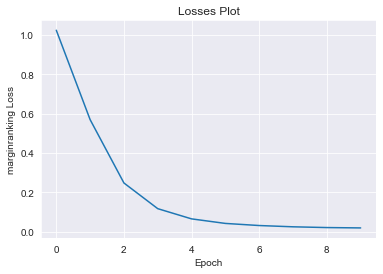

In [56]:
#model used TransE has only one representation for entities and relations, 
# so modules objects will be of length 1
print(result.model)
result.plot_losses()
# result.plot_early_stopping()

In [57]:
from typing import List
import pykeen.nn

entity_representation_modules: List['pykeen.nn.Representation'] = result.model.entity_representations
relation_representation_modules: List['pykeen.nn.Representation'] = result.model.relation_representations

In [58]:
entity_embeddings: pykeen.nn.Embedding = entity_representation_modules[0]
relation_embeddings: pykeen.nn.Embedding = relation_representation_modules[0]

In [59]:
print(entity_embeddings)
print(relation_embeddings)

Embedding(
  (_embeddings): Embedding(16232, 50)
)
Embedding(
  (_embeddings): Embedding(2, 50)
)


In [60]:
#Access embeddings by index (default arg returns all)
entity_embedding_tensor: torch.FloatTensor = entity_embeddings(indices=None)
relation_embedding_tensor: torch.FloatTensor = relation_embeddings(indices=None)

In [61]:
entcount = 0
for i in entity_embedding_tensor:
    entcount+=1
print(f"We have {entcount} entities embedded on {len(i)} dimensions")

relcount = 0
for i in relation_embedding_tensor:
    relcount+=1
print(f"We have {relcount} relations embedded on {len(i)} dimensions")

We have 16232 entities embedded on 50 dimensions
We have 2 relations embedded on 50 dimensions


I don't understand why we have 3 types of relations, when the input data should only have 2!:

* FIXED!: THis was happening because I forgot to rmv the header....

In [190]:
dINT["relation"].unique()

array(['LRinteraction', 'FIstring'], dtype=object)

Model should have been saved within one50... dir.
For future uses during development,  reload this default model. Later on, once we have added our own data or if prelim results are unsatisfactory, optimize methods and hyperparam.

# DR, clustering and visualisation

Now that we have a 50D KGE representing our data we can apply DR to generate a 2D space on which to visualise the entitites/nodes.

> From [pykeen docs](https://pykeen.readthedocs.io/en/stable/tutorial/translational_toy_example.html)

>*There was a lot of interesting follow-up discussion at !99 during which this code was implemented for re-use. One of the interesting points is that the relation plot is only applicable for translational distance models like TransE. Further, when models whose embeddings are higher than 2, a dimensionality reduction method must be used. For this, one of many of the tools from scikit-learn can be chosen. However, to make sure that the entities and relations are projected on the same axis, the dimensionality reduction model is first trained on the entity embeddings, then applied on both the entity embeddings and relation embeddings. Further, non-linear models like KPCA should not be used when plotting relations, since these _should_ correspond to linear transformations in embedding space.*

Furthermore, we should be able to cluster them and colour by cluster too. Hopefully there should be some overlap btwn the unsupervised clusters and pathway (biological/functional) annotations

In [2]:
trained_model = torch.load("one50_unstratified_stopped_transe/trained_model.pkl")
trained_model

TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(16232, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(2, 50)
    )
  )
  (weight_regularizers): ModuleList()
)

In [3]:
trained_model.entity_representations

ModuleList(
  (0): Embedding(
    (_embeddings): Embedding(16232, 50)
  )
)

In [4]:
#Construct nodes dataframe: detach() for now is meaningless as compute is CPU

entity_embeddings = trained_model.entity_representations[0](indices=None).detach().numpy()
entity_embeddings

array([[ 0.019457  ,  0.08779304,  0.07596195, ..., -0.03821058,
        -0.21000484, -0.19302951],
       [ 0.05486259,  0.13551868, -0.08792026, ..., -0.17098741,
        -0.09818703,  0.19641729],
       [ 0.12717593,  0.003318  ,  0.07573958, ...,  0.00599198,
        -0.12838149,  0.02735348],
       ...,
       [ 0.01967096, -0.25154817,  0.09352905, ...,  0.09732759,
        -0.00295671, -0.05159178],
       [ 0.24381754, -0.09071688,  0.12558883, ...,  0.13016768,
        -0.00063644,  0.09144283],
       [ 0.09037016, -0.23543361,  0.09393445, ...,  0.15796362,
        -0.00540877,  0.00322125]], dtype=float32)

To access a map of entities and relations to ID we must use the TriplesFactory object, so plz save it mate!

In [5]:
import json

with open("entityIDS.json") as infile:
    entityIDS = json.load(infile)

entityIDS

{'0': '',
 '1': '0610009B22Rik',
 '2': '0610010K14Rik',
 '3': '0610040J01Rik',
 '4': '1110004F10Rik',
 '5': '1110051M20Rik',
 '6': '1110059G10Rik',
 '7': '1190005I06Rik',
 '8': '1190007I07Rik',
 '9': '1500011B03Rik',
 '10': '1700001P01Rik',
 '11': '1700007K13Rik',
 '12': '1700009N14Rik',
 '13': '1700012B09Rik',
 '14': '1700013F07Rik',
 '15': '1700013G24Rik',
 '16': '1700013H16Rik',
 '17': '1700015G11Rik',
 '18': '1700016H13Rik',
 '19': '1700018F24Rik',
 '20': '1700019D03Rik',
 '21': '1700019N19Rik',
 '22': '1700020N01Rik',
 '23': '1700024G13Rik',
 '24': '1700028P14Rik',
 '25': '1700029J07Rik',
 '26': '1700037H04Rik',
 '27': '1700057G04Rik',
 '28': '1700066M21Rik',
 '29': '1700093K21Rik',
 '30': '1700123L14Rik',
 '31': '1700125H20Rik',
 '32': '1810009J06Rik',
 '33': '1810037I17Rik',
 '34': '1810046K07Rik',
 '35': '2200002D01Rik',
 '36': '2210010C04Rik',
 '37': '2210016L21Rik',
 '38': '2310011J03Rik',
 '39': '2310022B05Rik',
 '40': '2310039H08Rik',
 '41': '2310050C09Rik',
 '42': '2310057

In [10]:
testdf = pd.DataFrame(entity_embeddings, index=entityIDS.values())
testdf

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
,0.019457,0.087793,0.075962,-0.207849,0.119941,0.083714,0.031919,-0.177164,0.168293,-0.235517,...,-0.081181,-0.087506,0.289390,-0.202629,-0.232671,0.002109,0.018698,-0.038211,-0.210005,-0.193030
0610009B22Rik,0.054863,0.135519,-0.087920,-0.029824,-0.184402,-0.016395,0.093975,-0.003884,0.185336,-0.290509,...,-0.110672,0.077213,0.188933,0.129407,0.297762,-0.104044,-0.009220,-0.170987,-0.098187,0.196417
0610010K14Rik,0.127176,0.003318,0.075740,0.081813,-0.014230,0.272282,-0.137860,0.044193,-0.211423,0.097349,...,-0.007962,0.298000,0.086700,-0.207087,-0.048039,-0.167859,0.307144,0.005992,-0.128381,0.027353
0610040J01Rik,-0.108861,0.042057,-0.084533,-0.105771,0.080763,-0.068589,-0.110380,-0.157835,0.058100,0.165897,...,0.227152,0.005384,0.020007,-0.085966,-0.089837,0.167648,-0.210918,0.091719,0.059068,-0.141545
1110004F10Rik,0.008144,0.068054,-0.005740,-0.142302,0.022075,-0.113955,-0.111913,-0.077338,0.105471,0.219723,...,-0.168579,-0.133227,-0.165981,-0.155507,0.019961,-0.087179,-0.212431,0.026116,0.036709,-0.158244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mt-Nd3,0.070465,-0.029055,0.143706,0.313893,-0.115391,-0.203659,0.072741,-0.030219,0.142279,0.053968,...,-0.182829,-0.284645,-0.006026,-0.249784,-0.163879,0.226286,0.020546,0.177117,-0.008182,-0.019040
mt-Nd4,0.109107,-0.260516,0.134097,0.312004,0.020866,-0.206730,0.070304,0.042068,0.241827,-0.026155,...,-0.143915,-0.282426,-0.030162,-0.209875,-0.046357,0.205827,0.001434,0.151815,-0.013504,0.003306
mt-Nd4l,0.019671,-0.251548,0.093529,0.253221,-0.173212,-0.184696,0.122070,-0.017267,0.175466,-0.095987,...,-0.158391,-0.291835,0.030602,0.029707,0.049391,-0.006589,0.098745,0.097328,-0.002957,-0.051592
mt-Nd5,0.243818,-0.090717,0.125589,0.311155,0.257015,-0.204160,0.113248,-0.114310,0.082488,0.066766,...,-0.026658,-0.250067,-0.022394,0.142195,0.038209,0.235296,0.100383,0.130168,-0.000636,0.091443


## Compute PCA

Compute PCA and check %var explained by first 2 components.
Use them as prelim space on which to view scatter plot of gene/protein embeddings and then colour downstream by metadata (pathway info and clusters)

In [ ]:
import scprep
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

RDdataframe = PCA(n_components=2).fit_transform(testdf)
RDdataframe = pd.DataFrame(RDdataframe, index=entityIDS.values())
RDdataframe.index.name = "GeneSymbol"
RDdataframe

## Add metadata

In [21]:
print("Number of pathways in CellChatDB: ", len(pd.read_csv("dINT.tsv", sep="\t")["pathway"].unique()))
n_clusters = 12
clusters = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(testdf)
clusters

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Number of pathways in CellChatDB:  230


array([ 2, 10,  8, ...,  0,  0,  0], dtype=int32)

In [ ]:
#Append cluster column to RD dataframe.
RDdataframe.insert(len(RDdataframe.columns), "clust", clusters)

In [26]:
RDdataframe

,0,1,clust
GeneSymbol,,,
,0.061198,0.168258,2
0610009B22Rik,-0.114831,-0.048106,10
0610010K14Rik,0.119326,0.313578,8
0610040J01Rik,-0.006011,0.056494,0
1110004F10Rik,0.030857,-0.027825,6
...,...,...,...
mt-Nd3,0.006951,-0.058934,0
mt-Nd4,-0.004138,-0.064950,0
mt-Nd4l,0.080365,-0.052546,0


Get pathway info via REACTOME database (WIP)

- ReactomePathways DB has 2 columns, one for the pathway ID and another for the string name:
    - `curl -o ReactomePathways.txt https://reactome.org/download/current/ReactomePathways.txt`
<!-- - Ewas2Pathway DB links reactome protein/PTM ID with 2 pathway ID, lowest and higher level. -->
- ENSEMBL2Reactmoe DB can be used to link ENSEMBL with reactome pathways
    - `curl -o Ensembl2Reactome.txt https://reactome.org/download/current/Ensembl2Reactome.txt`
    - `curl -o Ensembl2Reactome_ALL.txt https://reactome.org/download/current/Ensembl2Reactome_All_Levels.txt`

Notes:
Future application could use Reactome IDS, for gene Symbols can be trivially converted and ENSP ID can also be converted from STRINGs or REACTOME's own Functional Interaction network DBS -> Need to pick the baseline EWAS ID for a non PTMd/modified entity. 

Also nOte that ideally Antibodies from a cytof panel woud need to be fuzzy matched against Reactome EWAS names to get a REactome ID specific to a certain PTM. OTherwise, use ENSP ID to ReactomeEWAS

In [49]:
from biomart import BiomartServer



#Load reactome database
dENSMUSpathwayR = pd.read_csv("Ensembl2Reactome.txt", sep="\t", header=None)
dENSMUSpathwayR = dENSMUSpathwayR.loc[dENSMUSpathwayR[5]=="Mus musculus"]
#Number of pathways
print(len(dENSMUSpathwayR[1].unique()))
print(len(dENSMUSpathwayR[3].unique()))

#Biomart
server = BiomartServer("http://useast.ensembl.org/biomart")
server.verbose = True

mart = server.datasets["mmusculus_gene_ensembl"]

response = mart.search({"attributes":["ensembl_peptide_id","mgi_symbol"]})

transDF = []

for line in response.raw.data.decode("utf-8").splitlines():
    line = line.split("\t")
    if len(line[0]) > 0: #Only get gene symbols with ENSP ID
        transDF.append(line)

transDF = pd.DataFrame(transDF, 
                columns=["ensembl_peptide_id","mgi_symbol"]
                ).drop_duplicates()

transDict = transDF.set_index("ensembl_peptide_id"
                ).to_dict(
                    #Transform DF into a dictionary but first set index
                )["mgi_symbol"]#Nested dict, so get first (and only item)
transDict

dENSMUSpathwayR[0] = dENSMUSpathwayR[0].map(transDict)
dENSMUSpathwayR.dropna(inplace=True)

#We have lost "only" 3 pathways from ENSP to geneSymbol missmatches
print(len(dENSMUSpathwayR[1].unique()))

#Turn into dictionary for mapping:
dENSMUSpathwayR = pd.DataFrame(dENSMUSpathwayR, 
                columns=[0,3]
                ).drop_duplicates()

dENSMUSpathwayR = dENSMUSpathwayR.set_index(0
                ).to_dict(
                    #Transform DF into a dictionary but first set index
                )[3]#Nested dict, so get first (and only item)

dENSMUSpathwayR

1360
1360
[BiomartServer:'http://useast.ensembl.org/biomart/martservice'] Fetching datasets
[BiomartServer:'http://useast.ensembl.org/biomart/martservice'] Fetching databases
[BiomartDatabase:'Ensembl Genes 107'] Fetching datasets
[BiomartDatabase:'Mouse strains 107'] Fetching datasets
[BiomartDatabase:'Sequence'] Fetching datasets
[BiomartDatabase:'Ontology'] Fetching datasets
[BiomartDatabase:'Genomic features 107'] Fetching datasets
[BiomartDatabase:'Ensembl Variation 107'] Fetching datasets
[BiomartDatabase:'Ensembl Regulation 107'] Fetching datasets
[BiomartDataset:'mmusculus_gene_ensembl'] Searching using following params:
{'attributes': ['ensembl_peptide_id', 'mgi_symbol']}
[BiomartDataset:'mmusculus_gene_ensembl'] Fetching attributes
[BiomartDataset] search query:
b'<Query virtualSchemaName="default" formatter="TSV" header="0" uniqueRows="1" datasetConfigVersion="0.6" count=""><Dataset name="mmusculus_gene_ensembl" interface="default"><Attribute name="ensembl_peptide_id" /><Att

{'Gnai3': 'Extra-nuclear estrogen signaling',
 'Cdc45': 'Activation of the pre-replicative complex',
 'Igf2': 'Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs)',
 'Apoh': 'Platelet degranulation ',
 'Cav2': 'Extra-nuclear estrogen signaling',
 'Scmh1': 'Regulation of PTEN gene transcription',
 'Cox5a': 'Cytoprotection by HMOX1',
 'Ngfr': 'Axonal growth stimulation',
 'Wnt3': 'WNT ligand biogenesis and trafficking',
 'Fer': 'Signaling by SCF-KIT',
 'Actr2': 'Clathrin-mediated endocytosis',
 'Gna12': 'Thrombin signalling through proteinase activated receptors (PARs)',
 'Sdhd': 'Citric acid cycle (TCA cycle)',
 'Fgf23': 'Post-translational protein phosphorylation',
 'Fgf6': 'PI5P, PP2A and IER3 Regulate PI3K/AKT Signaling',
 'Ccnd2': 'Drug-mediated inhibition of CDK4/CDK6 activity',
 'Ccl12': 'Chemokine receptors bind chemokines',
 'Th': 'Catecholamine biosynthesis',
 'Ins2': 'Insulin receptor recycling',
 'Scnn1g'

In [54]:
RDdataframe.index.map(dENSMUSpathwayR)

RDdataframe["pathway"] = RDdataframe.index.map(dENSMUSpathwayR)
RDdataframe

,0,1,clust,pathway
GeneSymbol,,,,
NaN,0.061198,0.168258,2,NaN
0610009B22Rik,-0.114831,-0.048106,10,NaN
0610010K14Rik,0.119326,0.313578,8,NaN
0610040J01Rik,-0.006011,0.056494,0,NaN
1110004F10Rik,0.030857,-0.027825,6,NaN
...,...,...,...,...
mt-Nd3,0.006951,-0.058934,0,Complex I biogenesis
mt-Nd4,-0.004138,-0.064950,0,Complex I biogenesis
mt-Nd4l,0.080365,-0.052546,0,NaN


**FUTURE?** 
Use instead higher level pathawys, for lower level results in over 1k pathways (and we just need a proof of concept that it is working)

In [ ]:
dENSMUSpathwayR = pd.read_csv("Ensembl2Reactome_ALL.txt", sep="\t", header=None)
dENSMUSpathwayR = dENSMUSpathwayR.loc[dENSMUSpathwayR[5]=="Mus musculus"]
dENSMUSpathwayR

## Viz

Clusters

/Users/ferran/Library/Python/3.9/lib/python/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:xlabel='PC-1', ylabel='PC-2'>

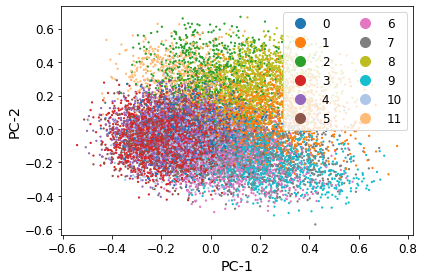

In [32]:
scprep.plot.scatter2d(RDdataframe, c=RDdataframe["clust"], 
    label_prefix="PC-", shuffle=True)

Single pathway "at random"

In [65]:
# pathawayOFinterest = "Glutathione conjugation"
pathawayOFinterest = "Mitochondrial translation termination"

hits = RDdataframe.index.isin(RDdataframe.loc[RDdataframe["pathway"]==pathawayOFinterest].index)

/Users/ferran/Library/Python/3.9/lib/python/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:xlabel='PC-1', ylabel='PC-2'>

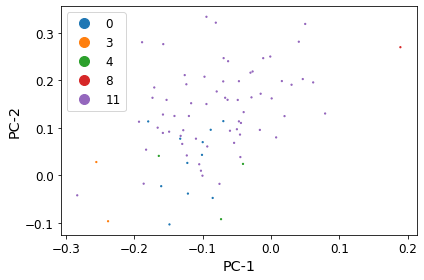

In [66]:
scprep.plot.scatter2d(RDdataframe,
    c=RDdataframe["clust"],
    mask=hits, 
    label_prefix="PC-", shuffle=True)

Biggest pathways

In [12]:
RDdataframe.groupby(["pathway"]).size().reset_index(name="counts").sort_values(by=["counts"], ascending=False)

,pathway,counts
56,Antigen processing: Ubiquitination & Proteasom...,271
496,Neutrophil degranulation,231
271,G alpha (i) signalling events,111
502,Nonsense Mediated Decay (NMD) enhanced by the ...,103
941,mRNA Splicing - Major Pathway,82
...,...,...
153,Cleavage of the damaged purine,1
151,Classical antibody-mediated complement activation,1
145,Chylomicron remodeling,1
144,Chylomicron clearance,1


/Users/ferran/Library/Python/3.9/lib/python/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ferran/Library/Python/3.9/lib/python/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ferran/Library/Python/3.9/lib/python/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ferran/Library/Python/3.9/lib/python/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ferran/Library/Python/3.9/lib/python/site

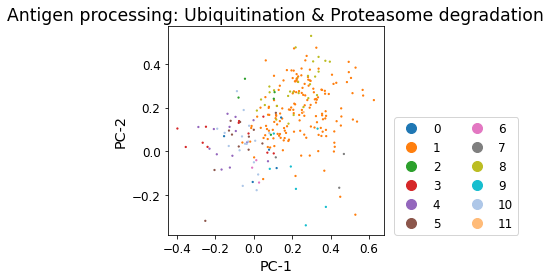

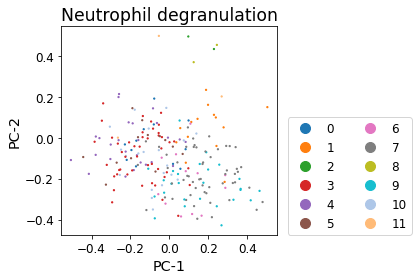

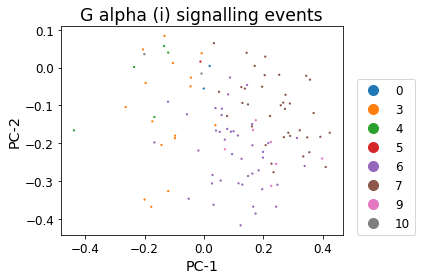

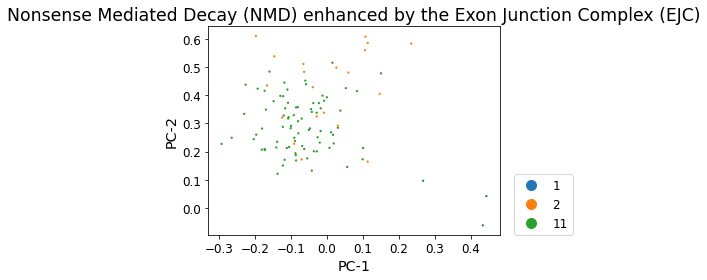

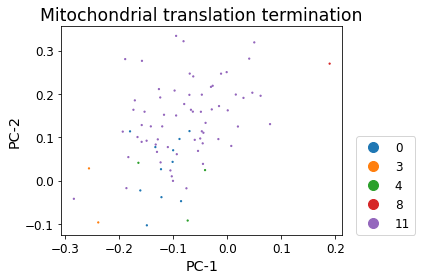

In [22]:
top5pathways = list(RDdataframe.groupby(["pathway"]).size().reset_index(name="counts").nlargest(5, "counts")["pathway"])
top5pathways

for i in top5pathways:
    hits = RDdataframe.index.isin(RDdataframe.loc[RDdataframe["pathway"]==i].index)
    scprep.plot.scatter2d(RDdataframe,
        c=RDdataframe["clust"],
        mask=hits, 
        title = i, label_prefix="PC-", 
        legend_loc=(1.05, 0), shuffle=True)

### TO-DO:

For now, b4 lab meeting and input from PIs, the immediate things to work on are:

- Exploration of KG metrics: i.e. connectivity, n of entities, and of relations
    - It would be intersting to see entities with the highests in and out degrees, or perhaps look into graph centrality measures akin to the downstream analyses they have in CellChat....?)
- Validate/QC current KGE:
    - Permutation-based validation of pathways: Check if entities belonging to a pathway lay closer on the embedding than 2 entities at random. 
    Would need to define a **distance metric** and to permute at random.
    - "Manual" exploration of the biggest pathways (those with the biggest number of entities).
        - How big are they?
        - Can they be compared with the unsupervised entity clusters?
    - Silhouette analysis (or similar?)
- ...
- Shift to REACTOME FI database: Key point here is that that database allows for information on multiple types of interaction (relations) following pseudo-boolean logic
- Shift to ENSEMBL IDs (prot or gene)? -> Not necessary but might be useful especially if we end up distinguishing btwn genes and proteins.

Ask for feedback from Smita on key points:

- Gene/Protein distinction?
- Pathway entities with belongs to pathway relation (as in Hetionet)?

## Save/Load metada

In [56]:
RDdataframe.to_csv("RDdataframe.csv")

In [2]:
RDdataframe = pd.read_csv("RDdataframe.csv", index_col="GeneSymbol")
RDdataframe

,0,1,clust,pathway
GeneSymbol,,,,
NaN,0.061198,0.168258,2,NaN
0610009B22Rik,-0.114831,-0.048106,10,NaN
0610010K14Rik,0.119326,0.313578,8,NaN
0610040J01Rik,-0.006011,0.056494,0,NaN
1110004F10Rik,0.030857,-0.027825,6,NaN
...,...,...,...,...
mt-Nd3,0.006951,-0.058934,0,Complex I biogenesis
mt-Nd4,-0.004138,-0.064950,0,Complex I biogenesis
mt-Nd4l,0.080365,-0.052546,0,NaN
